# Introduction

An electrocardiogram (ECG) is a simple test that can be used to check your heart's rhythm and electrical activity.

Sensors attached to the skin are used to detect the electrical signals produced by your heart each time it beats. These signals are recorded by a machine and are looked at by a doctor to see if they're unusual.

The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

<img src="pie.png">

**Ectopic heartbeats** are extra heartbeats that occur just before a regular beat. Ectopic beats are normal and usually not a cause for concern, though they can make people feel anxious.

# Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from sklearn import preprocessing
from sklearn.utils import resample

# Datasets Distributions

- ptbdb_abnormal.shape => 10506x188

- ptbdb_normal.shape => 4046x188

- mitbih_train.shape => 87554x188

- mitbih_test.shape => 21892x188

In [ ]:
for dirname, _, filenames in os.walk('/Pengenalan Pola'):
    for filename in filenames:
        pass

## Read the CSV File
- ABNORMAL_LABEL = 1,2,3,4
- NORMAL_LABEL = 0

In [ ]:
ptbdb_abnormal = pd.read_csv(os.path.join('ptbdb_abnormal.csv'),header=None)
ptbdb_normal = pd.read_csv(os.path.join('ptbdb_normal.csv'),header=None)
ptbdb_train = pd.concat([ptbdb_abnormal,ptbdb_normal],ignore_index=True)
mitbih_train = pd.read_csv(os.path.join('mitbih_train.csv'),header=None)
mitbih_test = pd.read_csv(os.path.join('mitbih_test.csv'),header=None)

## Visualizations of mitbih_train Dataset
- Observe that majority of the obsvns are of Label = 0

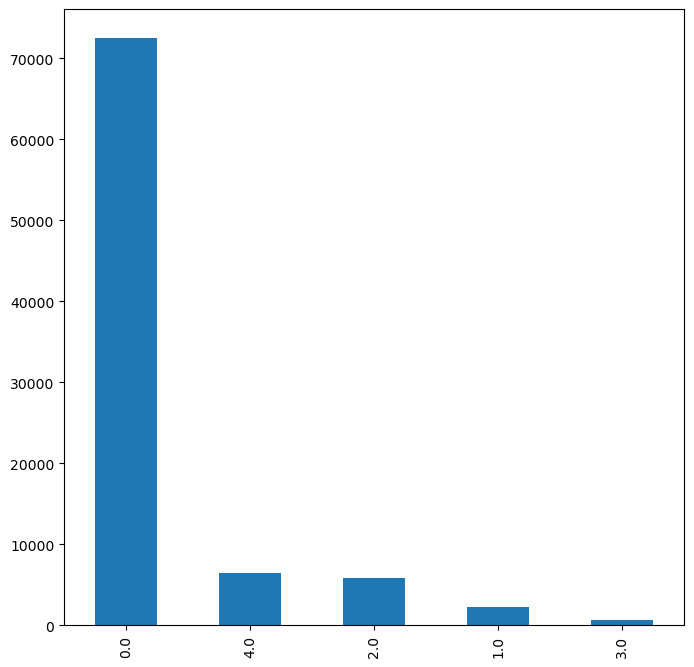

In [ ]:
fig,ax = plt.subplots(figsize = (8,8))
mitbih_train[187].value_counts().plot(ax = ax,kind = 'bar')
plt.show()

In [ ]:
full_train = pd.concat([mitbih_train,ptbdb_train],ignore_index = True)
full_train.shape

(102106, 188)

## Breaking Down the Train Dataset into X & Y

In [ ]:
full_train_y = full_train[187]
full_train_x = full_train.drop(columns = [187])

## Breaking Down the Test Dataset into X & Y

In [ ]:
mitbih_test_y = mitbih_test[187]
mitbih_test_x = mitbih_test.drop(columns = [187])

## Pie-Chart Visualization Training Label-Wise Distribution of Data

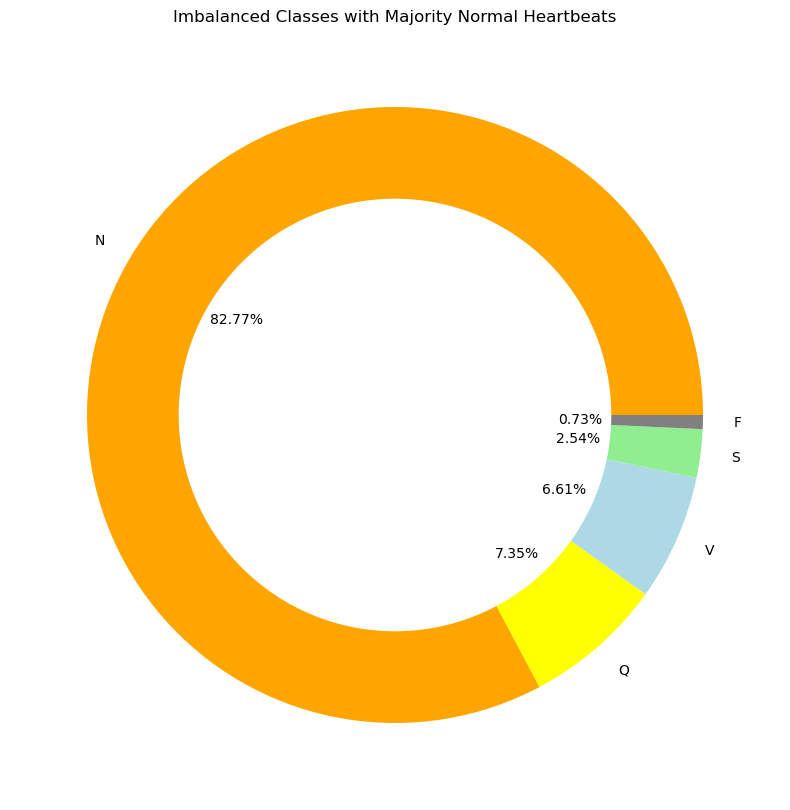

In [ ]:
plt.figure(figsize = (10,10))
plt.pie(mitbih_train[187].value_counts(), labels = ['N','Q','V','S','F'],
        colors = ['orange','yellow','lightblue','lightgreen','grey'], autopct = '%.2f%%')
plt.gcf().gca().add_artist(plt.Circle((0,0),0.7,color = 'white'))
plt.title('Imbalanced Classes with Majority Normal Heartbeats')
plt.show()

# Visualization of each ECG Class
Observing each entry of the 5 types of heartbeats.

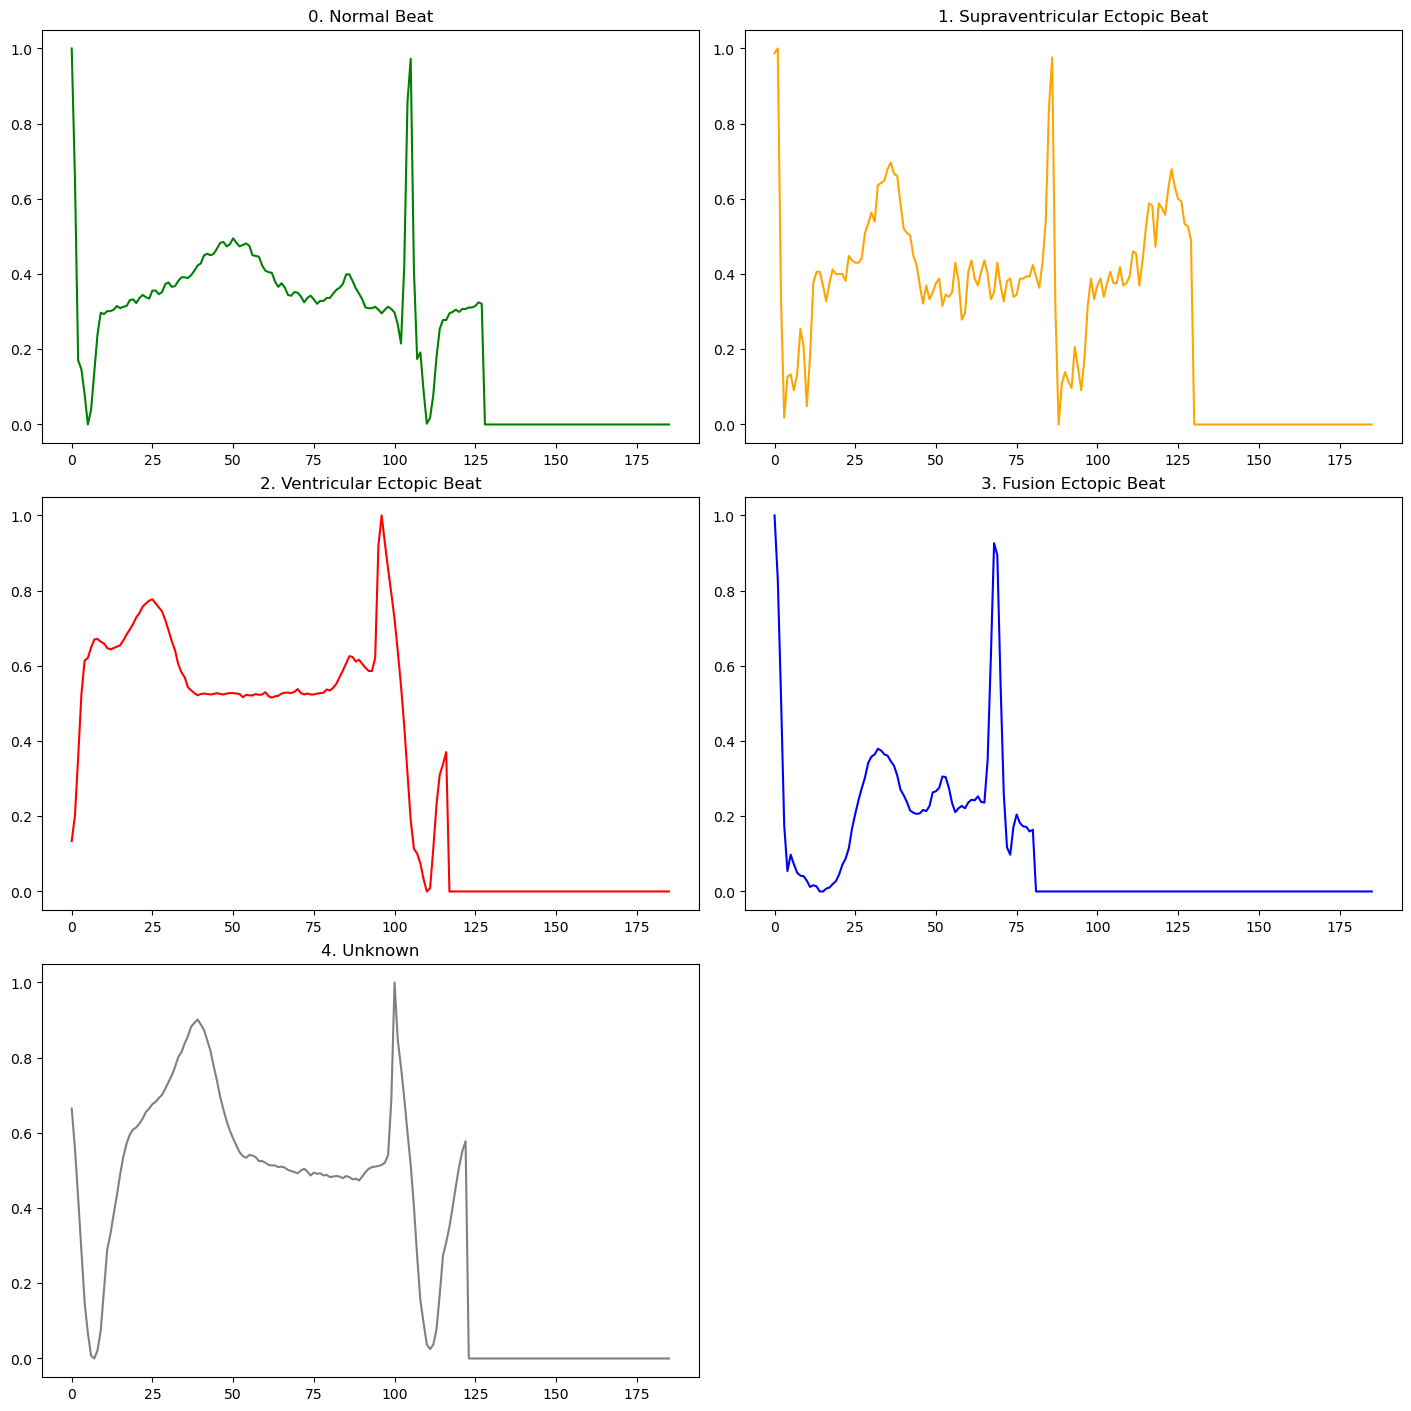

In [ ]:
plots= [['Normal Beat','Supraventricular Ectopic Beat'], ['Ventricular Ectopic Beat', 'Fusion Ectopic Beat'], ['Unknown']]
colors= [['green', 'orange'], ['red', 'blue'], ['grey']]
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(14,14))
fig.delaxes(axs[2,1])

for i in range(0,5,2):
    j=i//2
    axs[j][0].plot(mitbih_train[mitbih_train[187]==i%5].sample(1, random_state=100).iloc[0,:186], colors[j][0])
    axs[j][0].set_title('{}. {}'.format(i%5,plots[j][0]))

    if i%5!=4:
        axs[j][1].plot(mitbih_train[mitbih_train[187]==(i%5)+1].sample(1, random_state=100).iloc[0,:186], colors[j][1])
        axs[j][1].set_title('{}. {}'.format(i%5+1,plots[j][1]))

# Upsampling to Ensure an Even Class-Distribution
As we can observe in the above class-wise data distribution, 'N' has the highest number of records, with very few records for 'F' class.

1.0    20000
2.0    20000
3.0    20000
4.0    20000
0.0    20000
Name: 187, dtype: int64


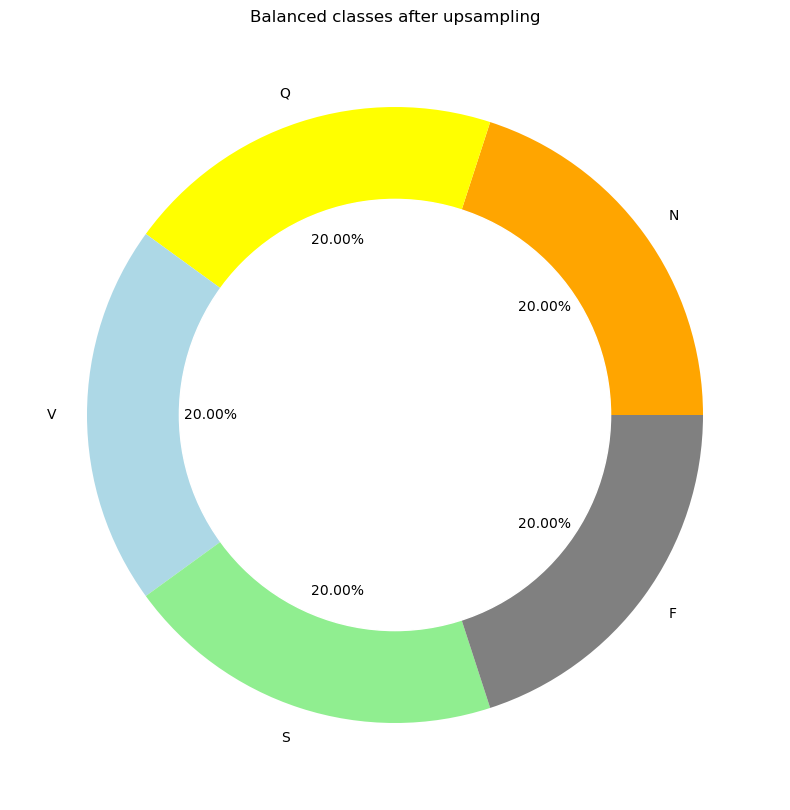

In [ ]:
df0=mitbih_train[mitbih_train[187]==0].sample(n=20000,random_state=10)
df1=mitbih_train[mitbih_train[187]==1]
df2=mitbih_train[mitbih_train[187]==2]
df3=mitbih_train[mitbih_train[187]==3]
df4=mitbih_train[mitbih_train[187]==4]

df1_upsampled=resample(df1,replace=True,n_samples=20000,random_state=100)
df2_upsampled=resample(df2,replace=True,n_samples=20000,random_state=101)
df3_upsampled=resample(df3,replace=True,n_samples=20000,random_state=102)
df4_upsampled=resample(df4,replace=True,n_samples=20000,random_state=103)
train_df=pd.concat([df1_upsampled,df2_upsampled,df3_upsampled,df4_upsampled,df0])

print(train_df[187].value_counts())
plt.figure(figsize=(10,10))
plt.pie(train_df[187].value_counts(), labels=['N','Q','V','S','F'],
        colors=['orange','yellow','lightblue','lightgreen','grey'], autopct='%.2f%%')
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.7, color='white' ))
plt.title('Balanced classes after upsampling')
plt.show()

# Modelling

## Creating the Model by Stacking Up Conv1D Layers
We will implement a simple Sequential TFv2 model with stacked up Convolutional layers.

These will essentially summarize chunks of data together based on filter-size, to produce feature-maps.

Finally we'll have a softmax output layer to give 5 predictictions since we have 5 classes.

In [ ]:
model=tf.keras.Sequential()

model.add(tf.keras.layers.Convolution1D(filters=50,kernel_size=20,activation='relu',kernel_initializer='glorot_uniform',input_shape=(187,1)))

#a1_0=> 187-20+1= 168,50
model.add(tf.keras.layers.MaxPool1D(pool_size=10,data_format='channels_first'))

#a1_1=> 50//10= 168,5
model.add(tf.keras.layers.Convolution1D(filters=20,kernel_size=15,activation='relu',kernel_initializer='glorot_uniform'))

#a2_0=> 168-15+1= 154,20
model.add(tf.keras.layers.MaxPool1D(pool_size=15,data_format='channels_first'))

#a2_1=> 20//15= 154,1
model.add(tf.keras.layers.Convolution1D(filters=10,kernel_size=10,activation='relu',kernel_initializer='glorot_uniform'))

#a3_0=> 154-10+1=145,10
model.add(tf.keras.layers.MaxPool1D(pool_size=10,data_format='channels_first'))

#a3_1=> 10//10=145,1
model.add(tf.keras.layers.Flatten())

#a4=> 145
model.add(tf.keras.layers.Dense(units=512,activation='relu',kernel_initializer='glorot_uniform'))

#a4=> 512
model.add(tf.keras.layers.Dense(units=128,activation='relu',kernel_initializer='glorot_uniform'))

#a5=> 128
model.add(tf.keras.layers.Dense(units=5,activation='softmax'))

model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

Metal device set to: Apple M1


2023-03-18 13:57:59.676349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-18 13:57:59.677157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 50)           1050      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 168, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 154, 20)           1520      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 154, 1)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 145, 10)           110       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 145, 1)           0

# Training the Model Part I

## Balanced Dataset

In [ ]:
mitbih_test_x2=np.asarray(mitbih_test_x)
mitbih_test_x2=mitbih_test_x2.reshape(-1,187,1)

## Dataset after Up-Sampling with an Even Distribution across the Classes

In [ ]:
train_df_X=np.asarray(train_df.iloc[:,:187]).reshape(-1,187,1)
train_df_Y=train_df.iloc[:,187]
print(train_df_X.shape)

hist=model.fit(train_df_X,train_df_Y,batch_size=64,epochs=20)

(100000, 187, 1)
Epoch 1/20


2023-03-18 13:59:59.576491: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-18 13:59:59.950355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 17s 9ms/step - loss: 0.5441 - acc: 0.8052
Epoch 2/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.2922 - acc: 0.8972
Epoch 3/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.2019 - acc: 0.9293
Epoch 4/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1563 - acc: 0.9462
Epoch 5/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1263 - acc: 0.9573
Epoch 6/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1080 - acc: 0.9641
Epoch 7/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0934 - acc: 0.9686
Epoch 8/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0831 - acc: 0.9723
Epoch 9/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0736 - acc: 0.9748
Epoch 10/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0663 - acc: 0.9778
Epoch 11/20
1563/1563 [=======

In [ ]:
_,acc=model.evaluate(mitbih_test_x2,mitbih_test_y,verbose=2)
print('Accuracy for the Balanced Dataset = ', round(acc*100,2),'%')

685/685 - 2s - loss: 0.2831 - acc: 0.9394 - 2s/epoch - 3ms/step
Accuracy for the Balanced Dataset =  93.94 %


# Training the Model Part II

## Unbalanced Dataset

In [ ]:
full_train_x2=np.asarray(full_train_x)
full_train_x2=full_train_x2.reshape(-1,187,1)
print(full_train_x2.shape)

hist=model.fit(full_train_x2,full_train_y,batch_size=64,epochs=20)

(102106, 187, 1)
Epoch 1/20
1596/1596 [==============================] - 15s 9ms/step - loss: 0.2067 - acc: 0.9273
Epoch 2/20
1596/1596 [==============================] - 14s 9ms/step - loss: 0.1254 - acc: 0.9555
Epoch 3/20
1596/1596 [==============================] - 14s 9ms/step - loss: 0.1030 - acc: 0.9627
Epoch 4/20
1596/1596 [==============================] - 14s 9ms/step - loss: 0.0888 - acc: 0.9682
Epoch 5/20
1596/1596 [==============================] - 15s 9ms/step - loss: 0.0786 - acc: 0.9714
Epoch 6/20
1596/1596 [==============================] - 14s 9ms/step - loss: 0.0709 - acc: 0.9746
Epoch 7/20
1596/1596 [==============================] - 15s 9ms/step - loss: 0.0647 - acc: 0.9766
Epoch 8/20
1596/1596 [==============================] - 14s 9ms/step - loss: 0.0600 - acc: 0.9784
Epoch 9/20
1596/1596 [==============================] - 14s 9ms/step - loss: 0.0534 - acc: 0.9810
Epoch 10/20
1596/1596 [==============================] - 14s 9ms/step - loss: 0.0509 - acc: 0.9819
Ep

In [ ]:
_,acc=model.evaluate(mitbih_test_x2,mitbih_test_y,verbose=2)
print('Accuracy for the Unbalanced Dataset = ',round(acc*100,2),'%')

685/685 - 2s - loss: 0.2031 - acc: 0.9643 - 2s/epoch - 3ms/step
Accuracy for the Unbalanced Dataset =  96.43 %


# Root Cause Analysis of the Validation Score Discrepancy

It seems the test-dataset of mitbih database performed better on the unbalanced dataset, rather than our standardized balanced dataset. This might be because of unbalanced class-distribution even in the test-dataset, as we observed in the train-dataset.

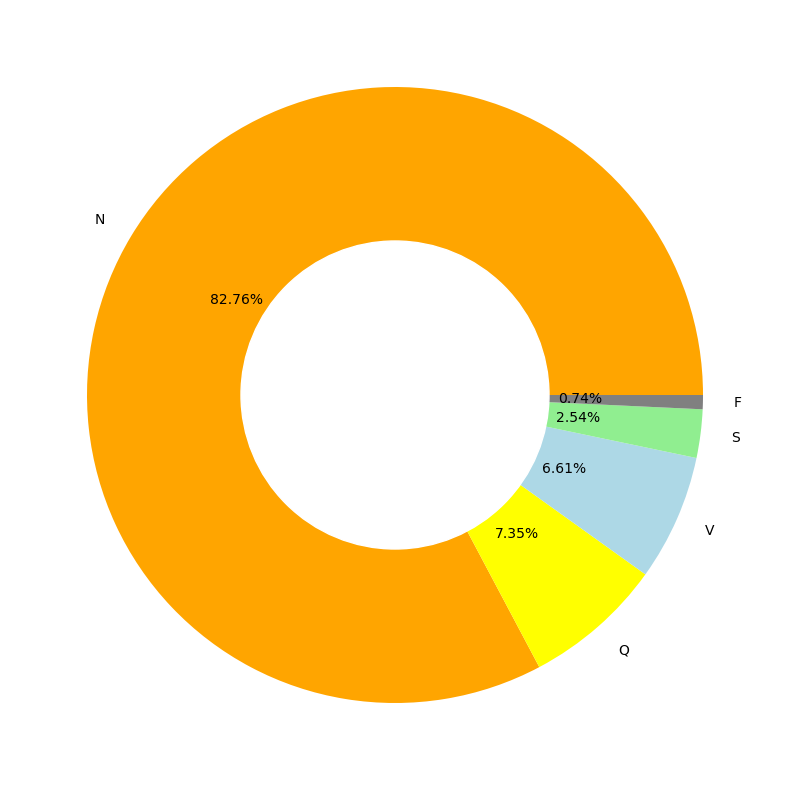

In [ ]:
dist=mitbih_test[187].value_counts()
plt.figure(figsize=(10,10))
plt.pie(x=dist, labels=['N','Q','V','S','F'], colors=['orange','yellow','lightblue','lightgreen','grey'], autopct='%0.2f%%')
plt.gcf().gca().add_artist(plt.Circle(xy=(0,0), radius=0.5, color='white'))
plt.show()